# Material para Estudo de Regressão

- Análise sobre o dataset do Kaggle do Boston Housing

In [1]:
## para tratar os dados

import pandas as pd
import numpy as np

In [2]:
## prepocessamento

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer  # pipeline com colunas de tipos diferentes
from sklearn.impute import SimpleImputer # missing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # escala das features
from category_encoders import TargetEncoder, OneHotEncoder  # tratamento de categóricas
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression  # seleção de features

## modelagem

import lightgbm as lgb

## configoracoes gerais

import warnings

warnings.filterwarnings('ignore')

In [3]:
## tratamento caso não haja cabeçalho no dataset

column_names = ['CRIM',
               'ZN',
               'INDUS',
               'CHAS',
               'NOX',
               'RM',
               'AGE',
               'DIS',
               'RAD',
               'TAX',
               'PTRATIO',
               'B',
               'LSTAT',
               'MEDV']


df = pd.read_csv('boston.csv', header=None, delimiter=r'\s+', names=column_names)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
df.shape

(506, 14)

In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
## verificando se há nulos nas colunas - mean para ver tx de missing

df.isna().count()

CRIM       506
ZN         506
INDUS      506
CHAS       506
NOX        506
RM         506
AGE        506
DIS        506
RAD        506
TAX        506
PTRATIO    506
B          506
LSTAT      506
MEDV       506
dtype: int64

## Análise Exploratória 

### Análise Exploratória de Preço

Se faz necessário saber técnicas de feature selection para saber técnicas de filtrar features mais relevantes.

Algumas técnicas de seleção:
- RFE (Recursive Feature Elimination)
- SelectKBest
- SelectFromModel

Como todas as colunas desse dataset são numéricas - vamos criar uma categórica para mostrar como podem ser feitos os tratamentos

In [7]:
df['CHAS'] = df['CHAS'].map({1: 'Yes', 0: 'No'})

df['CHAS'].value_counts()

CHAS
No     471
Yes     35
Name: count, dtype: int64

Caso houvessem muitas colunas e fosse inviável fazer a seleção de categóricas e numéricas, poderíamos fazer uma automação para tal.

In [8]:
categorical_columns = df.select_dtypes(exclude='number').columns.to_list()

numerical_columns = df.select_dtypes(include='number').columns.to_list()

In [9]:
df[categorical_columns].head()

,CHAS
0,No
1,No
2,No
3,No
4,No


In [10]:
df[numerical_columns].head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [11]:
numerical_columns = [feature for feature in numerical_columns if feature !='MEDV']

target = 'MEDV'

In [12]:
X = df[numerical_columns + categorical_columns]

y = df[target]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (354, 13)
X_test shape: (152, 13)
y_train shape: (354,)
y_test shape: (152,)


In [14]:
lgb_model = lgb.LGBMRegressor()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
    ]
)

# SelectKBest seleciona as features fazendo testes estatísticos
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func = f_regression, k=10)),
    ('model', lgb_model)   
])

# treina o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['CHAS'])])),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x000002CC36AB2160>)),
                ('model', LGBMRegressor())])

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-Squared (R2): {r2:.4f}')

Mean Squared Error (MSE): 11.7525
Root Mean Squared Error (RMSE): 3.4282
Mean Absolute Error (MAE): 2.3137
R-Squared (R2): 0.8423


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

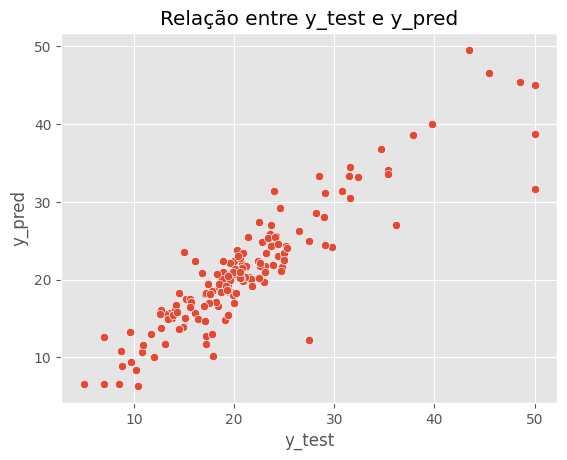

In [17]:
# Supondo que y_test e y_pred são arrays ou séries de pandas
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Relação entre y_test e y_pred')
plt.show()